In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import datetime as dt
from datetime import datetime, timedelta

# Reflect Tables into SQLAlchemy ORM

In [2]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func


In [3]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [4]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)


In [5]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [6]:
# Save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement

In [7]:
# Create our session (link) from Python to the DB
session = Session(engine)


# Exploratory Precipitation Analysis

In [8]:
# Find the most recent date in the data set.
most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
most_recent_date


('2017-08-23',)

(array([-500.,    0.,  500., 1000., 1500., 2000., 2500.]),
 [Text(-500.0, 0, '2017-05-27'),
  Text(0.0, 0, '2016-08-23'),
  Text(500.0, 0, '2016-11-09'),
  Text(1000.0, 0, '2017-01-28'),
  Text(1500.0, 0, '2017-04-18'),
  Text(2000.0, 0, '2017-07-10'),
  Text(2500.0, 0, '')])

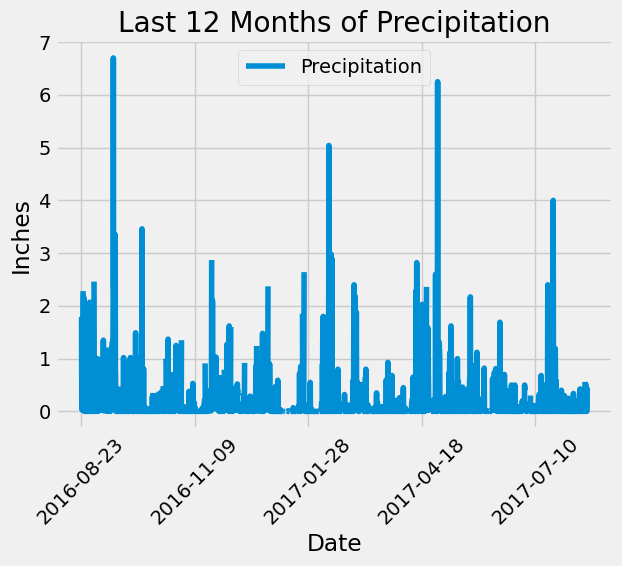

In [9]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
most_recent_date = ('2017-08-23',)  # Example most recent date
most_recent_date_str = most_recent_date[0]
most_recent_date_obj = pd.to_datetime(most_recent_date_str)

# Calculate the date one year from the last date in data set.
past_year = most_recent_date_obj - pd.DateOffset(days=366)

# Perform a query to retrieve the data and precipitation scores
query = f"SELECT date, prcp FROM measurement WHERE date >= '{past_year}'"
date_and_precip = pd.read_sql_query(query, engine)

# Save the query results as a Pandas DataFrame. Explicitly set the column names
date_and_precip.columns = ['Date', 'Precipitation']

# Sort the dataframe by date
date_and_precip = date_and_precip.sort_values("Date")

# Use Pandas Plotting with Matplotlib to plot the data
date_and_precip.plot(x="Date", y="Precipitation", kind="line", label="Precipitation")
plt.ylabel("Inches")
plt.title("Last 12 Months of Precipitation")
plt.xticks(rotation=45)

In [10]:
# Use Pandas to calculate the summary statistics for the precipitation data
count = date_and_precip['Precipitation'].count()
mean = date_and_precip['Precipitation'].mean()
std = date_and_precip['Precipitation'].std()
min = date_and_precip['Precipitation'].min()
q1 = date_and_precip['Precipitation'].quantile(.25)
q2 = date_and_precip['Precipitation'].quantile(.5)
q3 = date_and_precip['Precipitation'].quantile(.75)
max = date_and_precip['Precipitation'].max()

summary_stats = pd.DataFrame({
    "precipitation": [count, mean, std, min, q1, q2, q3, max]
}, index=["count", "mean", "std", "min", "25%", "50%", "75%", "max"])
summary_stats

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


## Exploratory Station Analysis

In [11]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(Measurement.station.distinct())).scalar()
total_stations

9

In [12]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
most_active_stations = session.query(Measurement.station, func.count(Measurement.station).label('observation_count')) \
                 .group_by(Measurement.station) \
                 .order_by(func.count(Measurement.station).desc()) \
                 .all()
most_active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [13]:
# Using the most active station id 
most_active_station = session.query(Measurement.station, func.count(Measurement.station).label('station_count')) \
    .group_by(Measurement.station) \
    .order_by(func.count(Measurement.station).desc()) \
    .first()
most_active_station_id = most_active_station[0]

# from the previous query, calculate the lowest, highest, and average temperature.
result = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)) \
    .filter(Measurement.station == most_active_station_id) \
    .first()
result

(54.0, 85.0, 71.66378066378067)

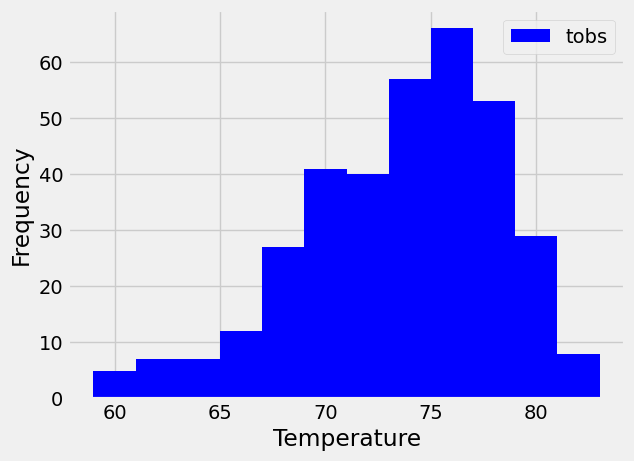

In [14]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
query = """
        SELECT date, tobs
        FROM measurement
        WHERE station = 'USC00519281' 
              AND date >= (SELECT DATE(MAX(date), '-12 months') FROM measurement)
        """
df = pd.read_sql_query(query, engine)

# Plotting results as a histogram
plt.hist(df['tobs'], bins=12, color='blue')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.legend(['tobs'])
plt.grid(True)
plt.show()

## Close Session

In [15]:
# Close Session
session.close()